In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import calc_loadings
from collections import defaultdict
from scipy.linalg import subspace_angles

### Technically, I did stratified Kfold on the entire dataset, which is fine given some mixture of presentations of each stimulus, but I believe the most strong imbalance in the data (and most relevant) is the imbalance in corrupted vs clear faces. Thus, I should probably pass binary stim IDs for clear vs corrupted faces to KFold and split on that...

### Load consolidated decoding dataframe

In [2]:
decoding_glom_path = '/home/marcush/Data/TsaoLabData/neural_control_output/degraded_decoding_small_batch/degraded_decoding_small_batch_glom.pickle'
with open(decoding_glom_path, 'rb') as f:
    dat_decode = pickle.load(f) 

df_decode = pd.DataFrame(dat_decode)

In [3]:
# Helpful ways to index / look at the df_decode
filtered_df_decode = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == 'AM') & (df_decode['dimreduc_method'] == 'PCA') & (df_decode['loader_args'].apply(lambda x: x.get('bin_width')) == 50) ]
df_decode.columns

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'predictions', 'loss',
       'decoding_object', 'decoder', 'decoder_args', 'thresholds', 'data_file',
       'loader', 'loader_args', 'task_args', 'data_path', 'results_file'],
      dtype='object')

### Extract useful params and get average classification error 

In [23]:
dimensions = np.unique(df_decode['dim'])
n_folds = np.unique(df_decode['fold_idx'])
bin_widths = np.unique(df_decode['loader_args'].apply(lambda x: x.get('bin_width')))
regions = np.unique(df_decode['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_decode['dimreduc_method'])

In [24]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
all_losses = recursive_defaultdict()

for dr_method in dimreduc_methods:
    for reg in regions:
        for bin_width in bin_widths:
            all_losses[dr_method][reg][bin_width] = np.zeros(len(dimensions))
            for idx, dim in enumerate(dimensions):

                df_decode_filt = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == reg) & (df_decode['dimreduc_method'] == dr_method) & (df_decode['loader_args'].apply(lambda x: x.get('bin_width')) == bin_width) & (df_decode['dim'] == dim)]
                avg_loss = np.mean(df_decode_filt['loss']) # averages loss over k_fold splits
                all_losses[dr_method][reg][bin_width][idx] = avg_loss

## Average classification accuracy in subspaces

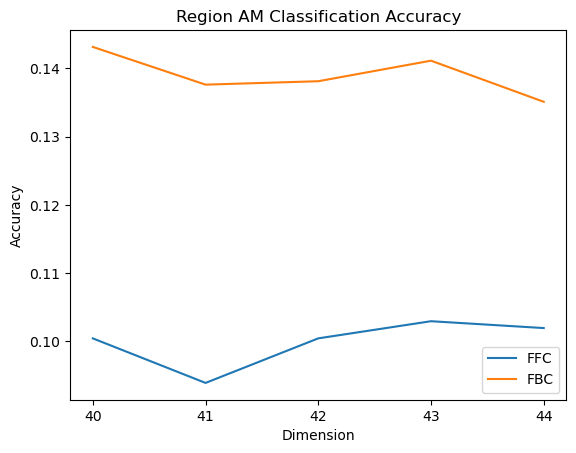

In [25]:
requested_ms = 50
region = 'AM'

FFC_losses = 1 - all_losses['PCA'][region][requested_ms]
FBC_losses = 1 - all_losses['LQGCA'][region][requested_ms]

plt.plot(dimensions, FFC_losses, label="FFC")
plt.plot(dimensions, FBC_losses, label="FBC")

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.show()


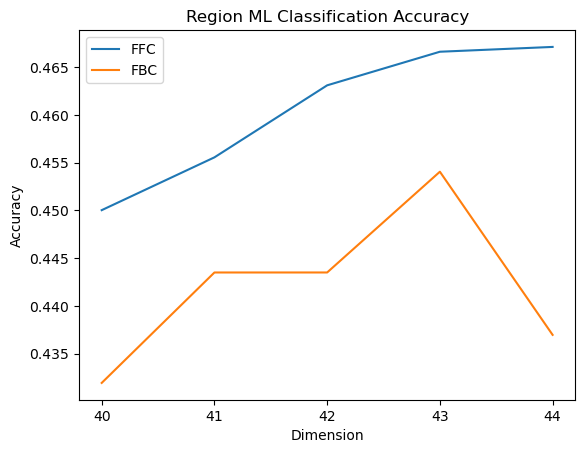

In [26]:
requested_ms = 25
region = 'ML'

FFC_losses = 1 - all_losses['PCA'][region][requested_ms]
FBC_losses = 1 - all_losses['LQGCA'][region][requested_ms]

plt.plot(dimensions, FFC_losses, label="FFC")
plt.plot(dimensions, FBC_losses, label="FBC")

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
sabes_df = pd.DataFrame(sabes_df)

DIM = 6

# Try the raw leverage scores instead
loadings_l = []
data_files = np.unique(sabes_df['data_file'].values)
for i, data_file in tqdm(enumerate(data_files)):
    loadings = []
    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            df_ = apply_df_filters(sabes_df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        
            loadings_fold.append(calc_loadings(V))


        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))

    for j in range(loadings[0].size):
        d_ = {}
        d_['data_file'] = data_file
        d_['FCCA_loadings'] = loadings[0][j]
        d_['PCA_loadings'] = loadings[1][j]
        # d_['DCA_loadings'] = loadings[2][j]
        d_['nidx'] = j
        loadings_l.append(d_)                

loadings_df = pd.DataFrame(loadings_l)